## Capstone Project

### The Battle of Neighborhoods | Finding a good place in Brooklyn, New York City

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import matplotlib.pyplot as plt
%matplotlib inline

print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.8.4

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.2 MB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-2.0.0

## 1. Download and Explore Dataset

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


#### Load data

In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [4]:
neighborhoods_data = newyork_data['features']

#### Tranform the data into a *pandas* dataframe

In [5]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

#### Then let's loop through the data and fill the dataframe one row at a time.

In [6]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [7]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


#### Information about Brooklyn - New York

Let's get the geographical coordinates of Brooklyn.

In [8]:
address = 'Brooklyn, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Brooklyn are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Brooklyn are 40.6501038, -73.9495823.


In [9]:
brooklyn_data = neighborhoods[neighborhoods['Borough'] == 'Brooklyn'].reset_index(drop=True)
brooklyn_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Brooklyn,Bay Ridge,40.625801,-74.030621
1,Brooklyn,Bensonhurst,40.611009,-73.995180
2,Brooklyn,Sunset Park,40.645103,-74.010316
3,Brooklyn,Greenpoint,40.730201,-73.954241
4,Brooklyn,Gravesend,40.595260,-73.973471


In [10]:
print('There are {} uniques neighborhood.'.format(len(brooklyn_data['Neighborhood'].unique())))

There are 70 uniques neighborhood.


#### Visualization the neighborhoods in Brooklyn

In [11]:
# create map of Brooklyn using latitude and longitude values
map_brooklyn = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(brooklyn_data['Latitude'], brooklyn_data['Longitude'], brooklyn_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_brooklyn)  
    
map_brooklyn

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [12]:
CLIENT_ID = 'YN1HJ1QQ0LCD1LZOEBRPEPTUBVYDTZA0ILTHRN3PPIWZBQWS' # your Foursquare ID
CLIENT_SECRET = 'KNFJNJESO4L3JM2RPHAULMHRCSOOBVZ1ZMD01AEWAVGDN15F' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: YN1HJ1QQ0LCD1LZOEBRPEPTUBVYDTZA0ILTHRN3PPIWZBQWS
CLIENT_SECRET:KNFJNJESO4L3JM2RPHAULMHRCSOOBVZ1ZMD01AEWAVGDN15F


In [13]:
search_query = 'Top 100 venues'
radius = 500 
LIMIT = 100 
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET,  VERSION, lat, lng, radius, LIMIT)
print(search_query + ' .... OK!')

Top 100 venues .... OK!


## 2. Explore Neighborhoods in Brooklyn

#### Let's create a function to get venue for all the neighborhoods in Brooklyn

In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called *brooklyn_venues*.

In [15]:
brooklyn_venues = getNearbyVenues(names=brooklyn_data['Neighborhood'],
                                   latitudes=brooklyn_data['Latitude'],
                                   longitudes=brooklyn_data['Longitude']
                                  )

Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker Heights
Gerritsen Beach
Marine Park
Clinton Hill
Sea Gate
Downtown
Boerum Hill
Prospect Lefferts Gardens
Ocean Hill
City Line
Bergen Beach
Midwood
Prospect Park South
Georgetown
East Williamsburg
North Side
South Side
Ocean Parkway
Fort Hamilton
Ditmas Park
Wingate
Rugby
Remsen Village
New Lots
Paerdegat Basin
Mill Basin
Fulton Ferry
Vinegar Hill
Weeksville
Broadway Junction
Dumbo
Homecrest
Highland Park
Madison
Erasmus


#### Let's check the size of the resulting dataframe

In [16]:
print(brooklyn_venues.shape)
brooklyn_venues.head()

(2778, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bay Ridge,40.625801,-74.030621,Pilo Arts Day Spa and Salon,40.624748,-74.030591,Spa
1,Bay Ridge,40.625801,-74.030621,Bagel Boy,40.627896,-74.029335,Bagel Shop
2,Bay Ridge,40.625801,-74.030621,Pegasus Cafe,40.623168,-74.031186,Breakfast Spot
3,Bay Ridge,40.625801,-74.030621,Leo's Casa Calamari,40.624200,-74.030931,Pizza Place
4,Bay Ridge,40.625801,-74.030621,Cocoa Grinder,40.623967,-74.030863,Juice Bar


#### Let's check how many venues were returned for each neighborhood

In [17]:
brooklyn_venues.groupby('Neighborhood').count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Bath Beach,47,47,47,47,47,47
Bay Ridge,80,80,80,80,80,80
Bedford Stuyvesant,28,28,28,28,28,28
Bensonhurst,36,36,36,36,36,36
Bergen Beach,6,6,6,6,6,6


#### Let's find out how many unique categories can be curated from all the returned venues

In [18]:
print('There are {} uniques categories.'.format(len(brooklyn_venues['Venue Category'].unique())))

There are 288 uniques categories.


## 3. Analyze Each Neighborhood

In [19]:
# one hot encoding
brooklyn_onehot = pd.get_dummies(brooklyn_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
brooklyn_onehot['Neighborhood'] = brooklyn_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [brooklyn_onehot.columns[-1]] + list(brooklyn_onehot.columns[:-1])
brooklyn_onehot = brooklyn_onehot[fixed_columns]

brooklyn_onehot.head()

,Yoga Studio,Accessories Store,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,History Museum,Hobby Shop,Hockey Field,Home Service,Hookah Bar,Hostel,Hotel,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundromat,Library,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Non-Profit,Noodle House,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoors & Recreation,Outlet Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pie Shop,Piercing Parlor,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Print Shop,Pub,Racetrack,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,Rock Club,Roller Rink,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skating Rink,Ski Area,Smoke Shop,Snack Place,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Tiki Bar,Toy / Game Store,Trail,Turkish Restaurant,Used Books

And let's examine the new dataframe size.

In [20]:
brooklyn_onehot.shape

(2778, 288)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [21]:
brooklyn_grouped = brooklyn_onehot.groupby('Neighborhood').mean().reset_index()
brooklyn_grouped

,Neighborhood,Yoga Studio,Accessories Store,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,History Museum,Hobby Shop,Hockey Field,Home Service,Hookah Bar,Hostel,Hotel,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundromat,Library,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Non-Profit,Noodle House,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoors & Recreation,Outlet Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pie Shop,Piercing Parlor,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Print Shop,Pub,Racetrack,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,Rock Club,Roller Rink,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skating Rink,Ski Area,Smoke Shop,Snack Place,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Tiki Bar,Toy / Game Store,Trail,Turkish Restaurant,Used Books

#### Let's confirm the new size

In [22]:
brooklyn_grouped.shape

(70, 288)

#### Let's print each neighborhood along with the top 5 most common venues

In [23]:
num_top_venues = 5

for hood in brooklyn_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = brooklyn_grouped[brooklyn_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bath Beach----
                venue  freq
0  Chinese Restaurant  0.04
1          Donut Shop  0.04
2        Dessert Shop  0.04
3         Pizza Place  0.04
4            Pharmacy  0.04


----Bay Ridge----
                 venue  freq
0   Italian Restaurant  0.08
1          Pizza Place  0.05
2                  Spa  0.05
3     Greek Restaurant  0.04
4  American Restaurant  0.04


----Bedford Stuyvesant----
          venue  freq
0   Coffee Shop  0.11
1          Café  0.07
2   Pizza Place  0.07
3           Bar  0.07
4  Gourmet Shop  0.04


----Bensonhurst----
                venue  freq
0  Chinese Restaurant  0.11
1  Italian Restaurant  0.08
2      Ice Cream Shop  0.06
3    Sushi Restaurant  0.06
4          Donut Shop  0.06


----Bergen Beach----
                venue  freq
0     Harbor / Marina  0.33
1          Playground  0.17
2      Baseball Field  0.17
3        Hockey Field  0.17
4  Athletics & Sports  0.17


----Boerum Hill----
          venue  freq
0   Coffee Shop  0.05
1  Dance St

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [24]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [25]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = brooklyn_grouped['Neighborhood']

for ind in np.arange(brooklyn_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(brooklyn_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bath Beach,Bubble Tea Shop,Italian Restaurant,Cantonese Restaurant,Pizza Place,Gas Station,Pharmacy,Dessert Shop,Fast Food Restaurant,Chinese Restaurant,Donut Shop
1,Bay Ridge,Italian Restaurant,Spa,Pizza Place,American Restaurant,Bar,Greek Restaurant,Bagel Shop,Hookah Bar,Thai Restaurant,Ice Cream Shop
2,Bedford Stuyvesant,Coffee Shop,Pizza Place,Café,Bar,Deli / Bodega,Tiki Bar,Park,Cocktail Bar,New American Restaurant,Bus Stop
3,Bensonhurst,Chinese Restaurant,Italian Restaurant,Donut Shop,Ice Cream Shop,Sushi Restaurant,Park,Pizza Place,Shabu-Shabu Restaurant,Sporting Goods Shop,Smoke Shop
4,Bergen Beach,Harbor / Marina,Hockey Field,Baseball Field,Athletics & Sports,Playground,Food Court,Food & Drink Shop,Food,Flower Shop,Food Stand


## 4. Cluster Neighborhoods

#### Run *k*-means to cluster the neighborhood into 5 clusters.

In [26]:
# set number of clusters
kclusters = 5

brooklyn_grouped_clustering = brooklyn_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(brooklyn_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 0, 0, 4, 3, 0, 4, 2, 2, 0], dtype=int32)

#### Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [27]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

brooklyn_merged = brooklyn_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
brooklyn_merged = brooklyn_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

brooklyn_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Brooklyn,Bay Ridge,40.625801,-74.030621,0,Italian Restaurant,Spa,Pizza Place,American Restaurant,Bar,Greek Restaurant,Bagel Shop,Hookah Bar,Thai Restaurant,Ice Cream Shop
1,Brooklyn,Bensonhurst,40.611009,-73.995180,4,Chinese Restaurant,Italian Restaurant,Donut Shop,Ice Cream Shop,Sushi Restaurant,Park,Pizza Place,Shabu-Shabu Restaurant,Sporting Goods Shop,Smoke Shop
2,Brooklyn,Sunset Park,40.645103,-74.010316,4,Mobile Phone Shop,Latin American Restaurant,Bank,Pizza Place,Bakery,Mexican Restaurant,Fried Chicken Joint,Gym,Deli / Bodega,Ice Cream Shop
3,Brooklyn,Greenpoint,40.730201,-73.954241,0,Bar,Pizza Place,Coffee Shop,Cocktail Bar,Yoga Studio,French Restaurant,Record Shop,Mexican Restaurant,Deli / Bodega,Bakery
4,Brooklyn,Gravesend,40.595260,-73.973471,4,Lounge,Pizza Place,Bakery,Chinese Restaurant,Gym,Italian Restaurant,Cosmetics Shop,Farmers Market,Men's Store,Baseball Field


In [28]:
brooklyn_merged.dtypes

Borough                    object
Neighborhood               object
Latitude                  float64
Longitude                 float64
Cluster Labels              int32
1st Most Common Venue      object
2nd Most Common Venue      object
3rd Most Common Venue      object
4th Most Common Venue      object
5th Most Common Venue      object
6th Most Common Venue      object
7th Most Common Venue      object
8th Most Common Venue      object
9th Most Common Venue      object
10th Most Common Venue     object
dtype: object

#### Finally, let's visualize the resulting clusters

In [29]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(brooklyn_merged['Latitude'], brooklyn_merged['Longitude'], brooklyn_merged['Neighborhood'], brooklyn_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

#### Cluster 0

In [30]:
brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 0, brooklyn_merged.columns[[1] + list(range(5, brooklyn_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bay Ridge,Italian Restaurant,Spa,Pizza Place,American Restaurant,Bar,Greek Restaurant,Bagel Shop,Hookah Bar,Thai Restaurant,Ice Cream Shop
3,Greenpoint,Bar,Pizza Place,Coffee Shop,Cocktail Bar,Yoga Studio,French Restaurant,Record Shop,Mexican Restaurant,Deli / Bodega,Bakery
6,Sheepshead Bay,Turkish Restaurant,Dessert Shop,Sandwich Place,Yoga Studio,Diner,Russian Restaurant,Restaurant,Creperie,Pizza Place,Buffet
11,Kensington,Thai Restaurant,Grocery Store,Pizza Place,Ice Cream Shop,Sandwich Place,Music Venue,Liquor Store,Supermarket,Furniture / Home Store,Mexican Restaurant
12,Windsor Terrace,Diner,Park,Plaza,Grocery Store,Deli / Bodega,Bagel Shop,Chinese Restaurant,Café,Butcher,French Restaurant
13,Prospect Heights,Bar,Mexican Restaurant,Bakery,Cocktail Bar,Wine Shop,Thai Restaurant,Café,Gourmet Shop,Pizza Place,Southern / Soul Food Restaurant
15,Williamsburg,Coffee Shop,Bagel Shop,Yoga Studio,Breakfast Spot,Latin American Restaurant,Greek Restaurant,Tapas Restaurant,Taco Place,Liquor Store,Lounge
16,Bushwick,Bar,Mexican Restaurant,Coffee Shop,Deli / Bodega,Discount Store,Thrift / Vintage Store,Bakery,Vegetarian / Vegan Restaurant,Café,Pizza Place
17,Bedford Stuyvesant,Coffee Shop,Pizza Place,Café,Bar,Deli / Bodega,Tiki Bar,Park,Cocktail Bar,New American Restaurant,Bus Stop
18,Brooklyn Heights,Deli / Bodega,Yoga Studio,Park,Italian Restaurant,Bakery,Cosmetics Shop,Gym,Pharmacy,Gym / Fitness Center,Scenic Lookout


#### Cluster 1

In [31]:
brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 1, brooklyn_merged.columns[[1] + list(range(5, brooklyn_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
30,Mill Island,Pool,Women's Store,Flower Shop,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food


#### Cluster 2

In [32]:
brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 2, brooklyn_merged.columns[[1] + list(range(5, brooklyn_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Brighton Beach,Restaurant,Russian Restaurant,Eastern European Restaurant,Gourmet Shop,Mobile Phone Shop,Beach,Pharmacy,Sushi Restaurant,Supplement Shop,Coffee Shop
10,East Flatbush,Department Store,Pharmacy,Moving Target,Print Shop,Food & Drink Shop,Supermarket,Fast Food Restaurant,Caribbean Restaurant,Liquor Store,Park
14,Brownsville,Moving Target,Fried Chicken Joint,Restaurant,Farmers Market,Chinese Restaurant,Spanish Restaurant,Park,Performing Arts Venue,Trail,Convenience Store
25,Cypress Hills,Latin American Restaurant,Fried Chicken Joint,Ice Cream Shop,Donut Shop,Fast Food Restaurant,Bank,South American Restaurant,Food,Gas Station,Supermarket
26,East New York,Deli / Bodega,Fast Food Restaurant,Salon / Barbershop,Fried Chicken Joint,Caribbean Restaurant,Plaza,Bus Station,Pizza Place,Metro Station,Child Care Service
29,Flatlands,Pharmacy,Fried Chicken Joint,Fast Food Restaurant,Caribbean Restaurant,Lounge,Discount Store,Nightclub,Bus Station,Video Store,Paper / Office Supplies Store
32,Coney Island,Baseball Stadium,Monument / Landmark,Pharmacy,Music Venue,Food Stand,Brewery,Skating Rink,Caribbean Restaurant,Beach,Theme Park Ride / Attraction
44,City Line,Donut Shop,Fried Chicken Joint,Mobile Phone Shop,Shoe Store,Grocery Store,Pizza Place,Pharmacy,Cuban Restaurant,Cosmetics Shop,Coffee Shop
47,Prospect Park South,Pizza Place,Caribbean Restaurant,Grocery Store,Clothing Store,Fast Food Restaurant,Fried Chicken Joint,Mobile Phone Shop,Donut Shop,Latin American Restaurant,Mexican Restaurant
55,Wingate,Fried Chicken Joint,Discount Store,Bakery,Nightclub,Flower Shop,Other Great Outdoors,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market


#### Cluster 3

In [33]:
brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 3, brooklyn_merged.columns[[1] + list(range(5, brooklyn_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
31,Manhattan Beach,Café,Ice Cream Shop,Sandwich Place,Bus Stop,Food,Harbor / Marina,Playground,Beach,Fish & Chips Shop,Farmers Market
45,Bergen Beach,Harbor / Marina,Hockey Field,Baseball Field,Athletics & Sports,Playground,Food Court,Food & Drink Shop,Food,Flower Shop,Food Stand


#### Cluster 4

In [34]:
brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 4, brooklyn_merged.columns[[1] + list(range(5, brooklyn_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Bensonhurst,Chinese Restaurant,Italian Restaurant,Donut Shop,Ice Cream Shop,Sushi Restaurant,Park,Pizza Place,Shabu-Shabu Restaurant,Sporting Goods Shop,Smoke Shop
2,Sunset Park,Mobile Phone Shop,Latin American Restaurant,Bank,Pizza Place,Bakery,Mexican Restaurant,Fried Chicken Joint,Gym,Deli / Bodega,Ice Cream Shop
4,Gravesend,Lounge,Pizza Place,Bakery,Chinese Restaurant,Gym,Italian Restaurant,Cosmetics Shop,Farmers Market,Men's Store,Baseball Field
7,Manhattan Terrace,Ice Cream Shop,Pizza Place,Chinese Restaurant,Donut Shop,Bakery,Organic Grocery,Grocery Store,Coffee Shop,Liquor Store,Bus Stop
8,Flatbush,Mexican Restaurant,Deli / Bodega,Coffee Shop,Caribbean Restaurant,Bank,Hardware Store,Bagel Shop,Gastropub,Lounge,Sandwich Place
9,Crown Heights,Pizza Place,Café,Museum,Bakery,Moving Target,Liquor Store,Salon / Barbershop,Supermarket,Coffee Shop,Kosher Restaurant
27,Starrett City,Moving Target,Bus Stop,Pizza Place,Caribbean Restaurant,Pharmacy,Bus Station,Supermarket,Chinese Restaurant,Donut Shop,American Restaurant
33,Bath Beach,Bubble Tea Shop,Italian Restaurant,Cantonese Restaurant,Pizza Place,Gas Station,Pharmacy,Dessert Shop,Fast Food Restaurant,Chinese Restaurant,Donut Shop
34,Borough Park,Bank,Pizza Place,Fast Food Restaurant,Pharmacy,Café,Eastern European Restaurant,Grocery Store,Metro Station,Coffee Shop,Restaurant
37,Marine Park,Basketball Court,Pizza Place,Park,Chinese Restaurant,Baseball Field,Gym,Athletics & Sports,Soccer Field,Deli / Bodega,Ice Cream Shop


## 6. Neighborhood comparison based on indicators

#### Read the csv file with Brooklyn's indicators: average_sale_price x neighboors and population

In [35]:
brooklyn_indicators = pd.read_csv('Brooklyn_indicators.csv', sep=';', dtype = {'Average_Sale_Price' 'Population' : 'Int64'})

#### Join data sets: brooklyn data and indicators

In [36]:
indicator_neighboorhood = brooklyn_data.join(brooklyn_indicators.set_index('Neighborhood'), on='Neighborhood')

Drop columns 'Borough','Latitude','Longitude'

In [37]:
indicator_neighboorhood.drop(['Borough','Latitude','Longitude'], axis=1, inplace=True)

In [38]:
indicator_neighboorhood.head()

,Neighborhood,Average_Sale_Price,Population
0,Bay Ridge,1247090.0,79371.0
1,Bensonhurst,1206425.0,62978.0
2,Sunset Park,1245763.0,7234.0
3,Greenpoint,1888497.0,34719.0
4,Gravesend,1038580.0,29436.0


## 6.1. Average Sale Price indicator 

#### Get average_sale_price indicator, delete null values:

In [39]:
avg_sale_price = indicator_neighboorhood[indicator_neighboorhood['Average_Sale_Price'].notnull()]

In [40]:
avg_sale_price.drop(['Population'], axis=1, inplace=True)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [41]:
avg_sale_price.head()

,Neighborhood,Average_Sale_Price
0,Bay Ridge,1247090.0
1,Bensonhurst,1206425.0
2,Sunset Park,1245763.0
3,Greenpoint,1888497.0
4,Gravesend,1038580.0


#### Visualization the indicator average_sale_price indicator x Neighborhood:

In [42]:
avg_sale_price.set_index('Neighborhood',inplace=True,drop=True)

In [43]:
avg_sale_price_order = avg_sale_price.sort_values(by=['Average_Sale_Price'], ascending=False)

#### The 10 neighborhoods with the highest average sales price

In [44]:
avg_sale_price_10_first = avg_sale_price_order.head(10)
avg_sale_price_10_first

,Average_Sale_Price
Neighborhood,
Brooklyn Heights,4786786.0
Cobble Hill,4557143.0
Downtown,3750000.0
Park Slope,3329971.0
Boerum Hill,2955575.0
Fort Greene,2810237.0
Carroll Gardens,2719967.0
Prospect Heights,2639444.0
Clinton Hill,2131497.0


#### Visualization - The 10 neighborhoods with the highest average sales price

<AxesSubplot:ylabel='Neighborhood'>

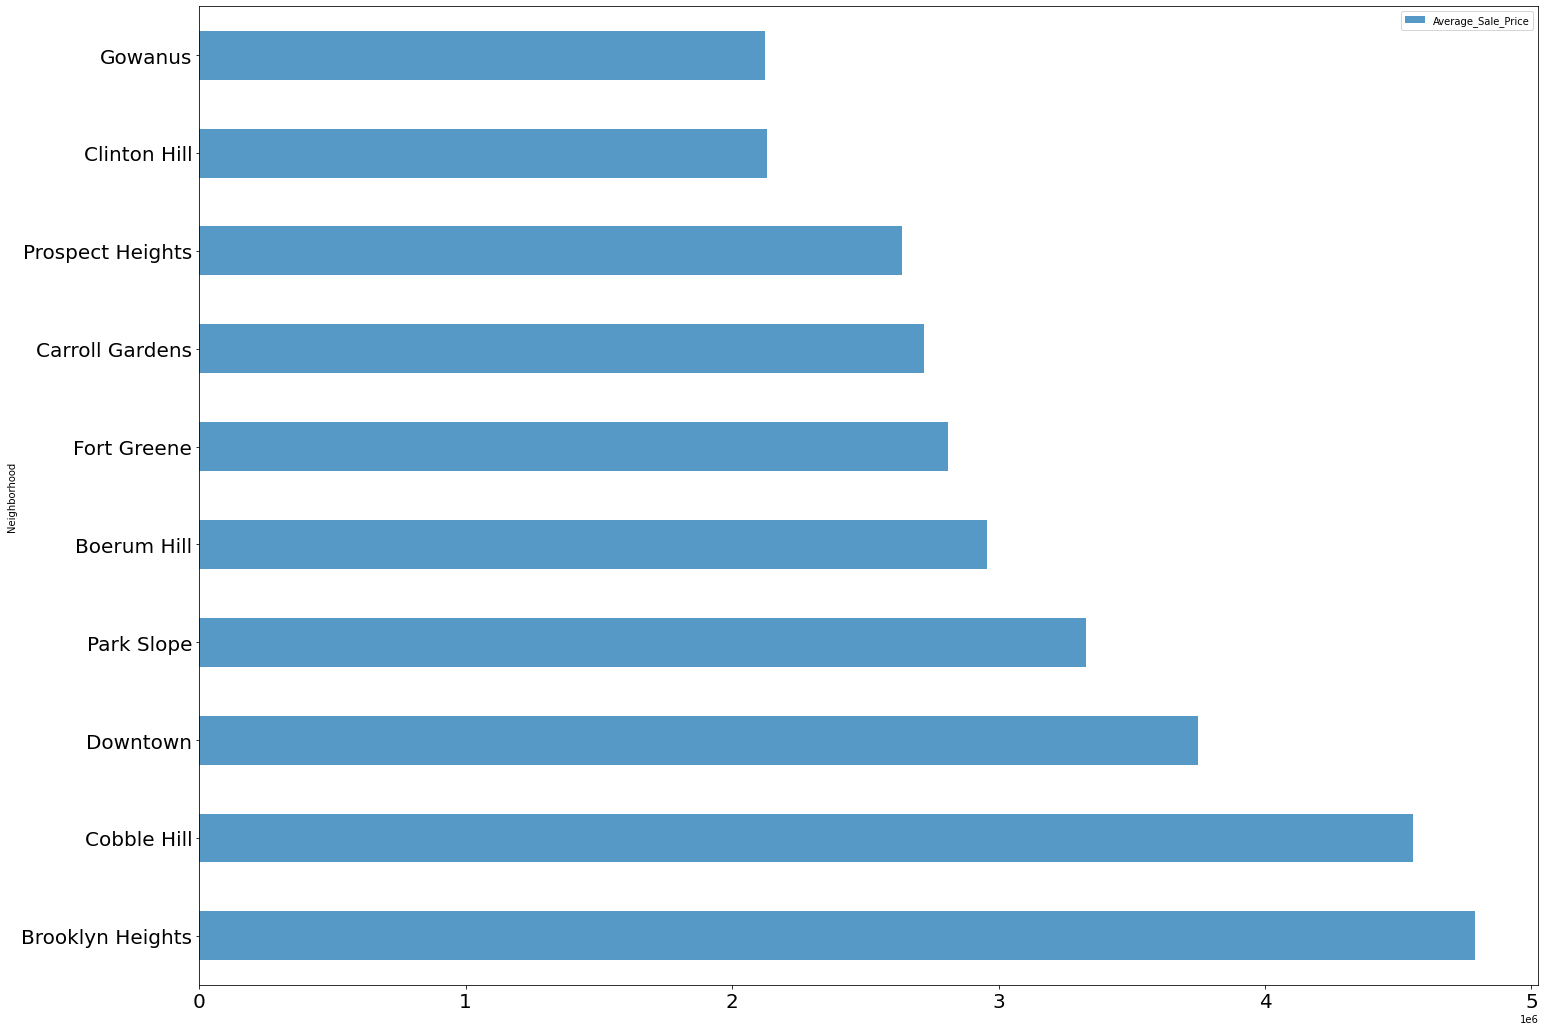

In [45]:
avg_sale_price_10_first.plot(kind='barh',figsize=(24,18),alpha=0.75, fontsize=20)

#### The 10 neighborhoods with the lowest average sales price

In [46]:
avg_sale_price_10_last = avg_sale_price_order.tail(10)
avg_sale_price_10_last

,Average_Sale_Price
Neighborhood,
Bergen Beach,810757.0
Marine Park,778474.0
Brighton Beach,674502.0
Cypress Hills,653465.0
Coney Island,630000.0
Flatlands,616772.0
Canarsie,615787.0
East New York,610108.0
Brownsville,606433.0


#### Visualization - The 10 neighborhoods with the lowest average sales price

<AxesSubplot:ylabel='Neighborhood'>

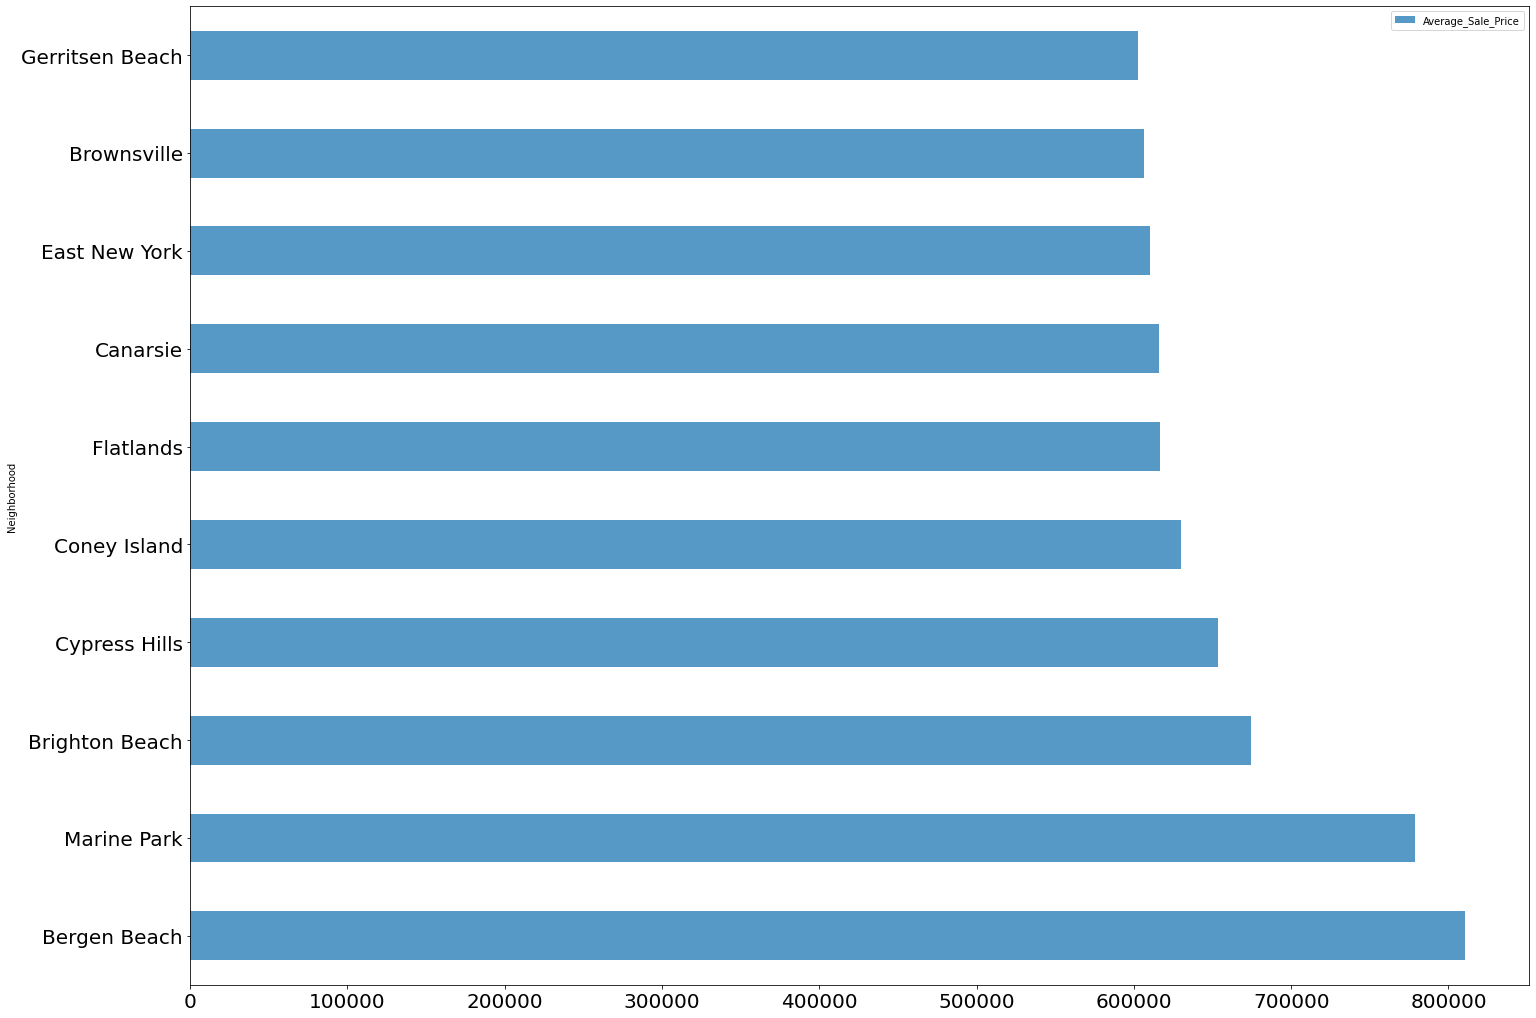

In [47]:
avg_sale_price_10_last.plot(kind='barh',figsize=(24,18),alpha=0.75, fontsize=20)


## 6.1. Population indicator

#### Get population indicator, delete null values:

In [48]:
population = indicator_neighboorhood[indicator_neighboorhood['Population'].notnull()]

In [49]:
population.drop(['Average_Sale_Price'], axis=1, inplace=True)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [50]:
population.set_index('Neighborhood',inplace=True,drop=True)

In [51]:
population_order = population.sort_values(by=['Population'], ascending=False)

#### The 10 neighborhoods with the highest population

In [52]:
population_10_first = population_order.head(10)
population_10_first

,Population
Neighborhood,
Borough Park,106357.0
Flatbush,105804.0
Crown Heights,103169.0
East New York,91958.0
Canarsie,83693.0
Bay Ridge,79371.0
Bedford Stuyvesant,70713.0
Park Slope,67649.0
Gowanus,67649.0


#### Visualization - The 10 neighborhoods with the highest population

<AxesSubplot:ylabel='Neighborhood'>

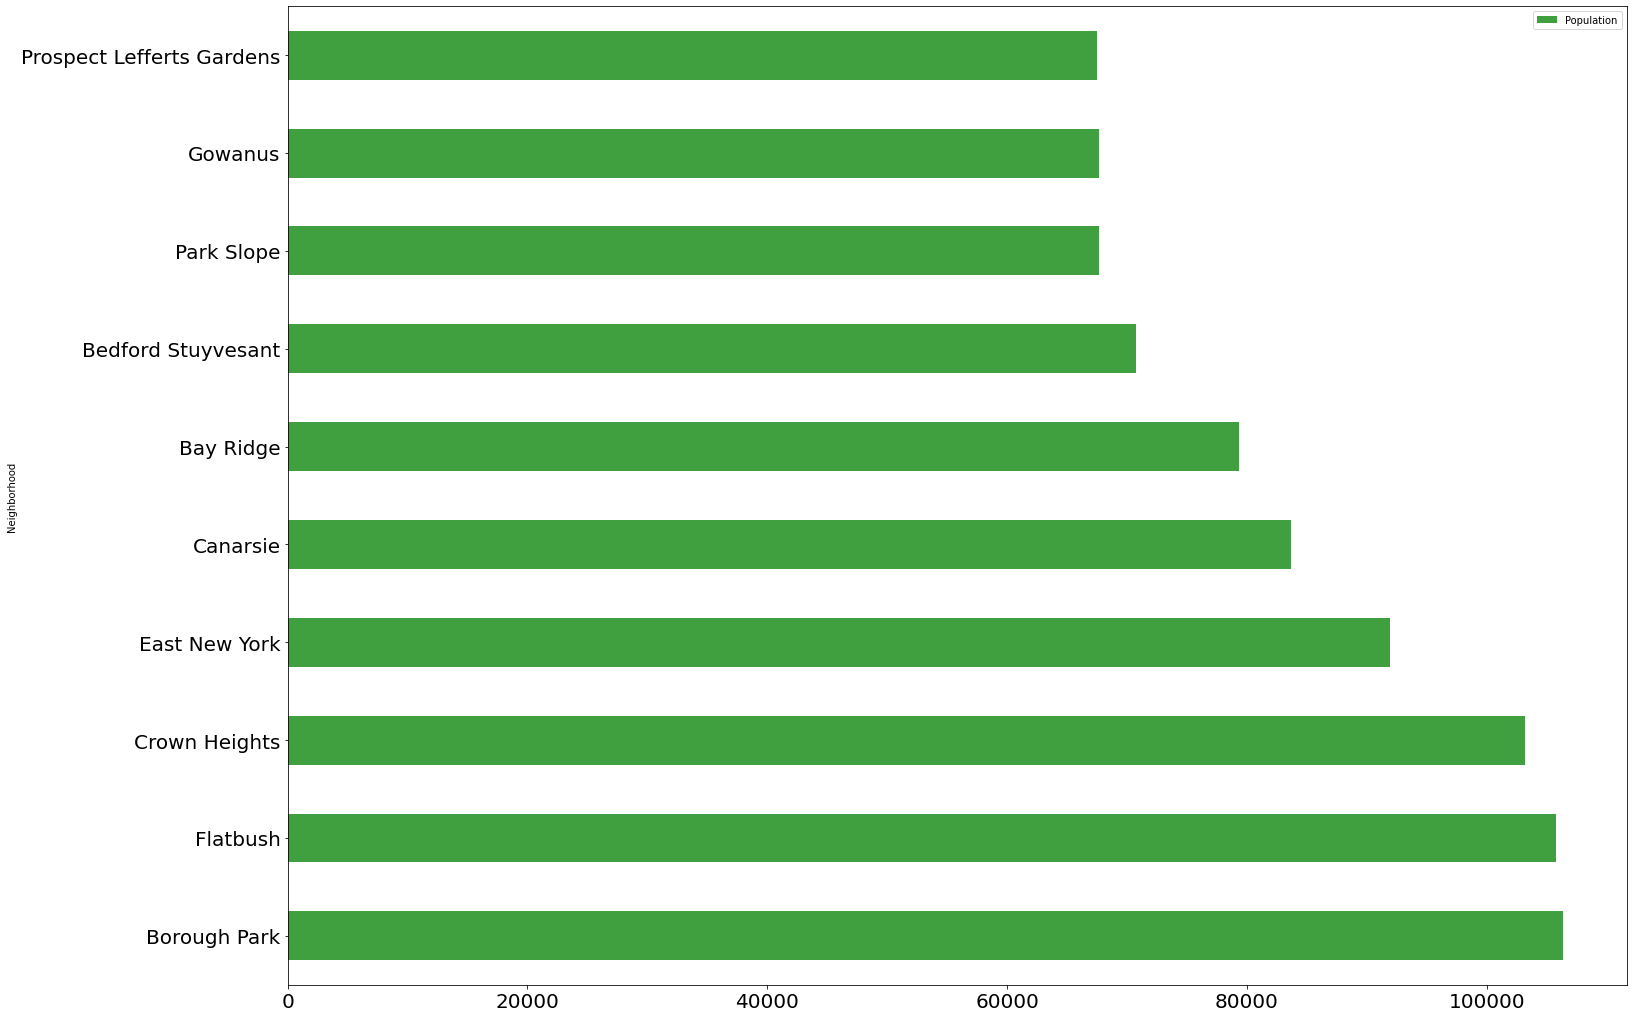

In [53]:
population_10_first.plot(kind='barh',figsize=(24,18), color='green',alpha=0.75, fontsize=20)

#### The 10 neighborhoods with the lowest population

In [54]:
population_10_last = population_order.tail(10)
population_10_last

,Population
Neighborhood,
Gravesend,29436.0
Fort Greene,26079.0
Brooklyn Heights,22887.0
Cobble Hill,22887.0
Windsor Terrace,20988.0
Paerdegat Basin,20299.0
Prospect Heights,19849.0
Starrett City,13354.0
Sunset Park,7234.0


#### Visualization - The 10 neighborhoods with the lowest population

<AxesSubplot:ylabel='Neighborhood'>

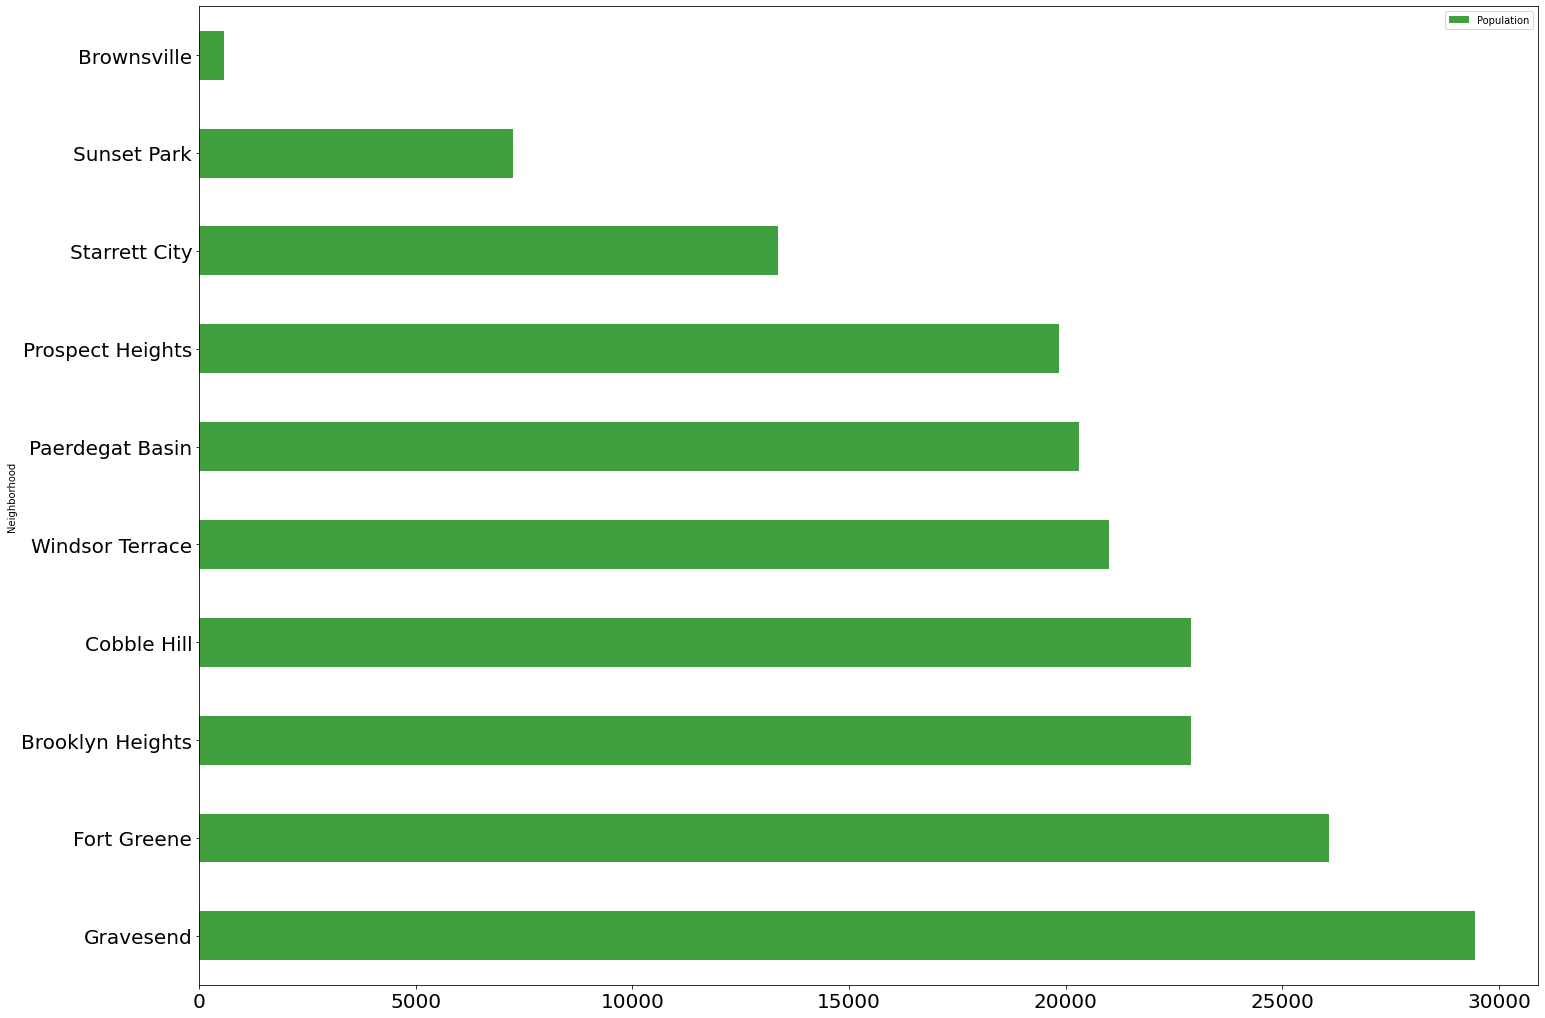

In [55]:
population_10_last.plot(kind='barh',figsize=(24,18), color='green',alpha=0.75, fontsize=20)

## Conclusion

In this project, using k-means cluster algorithm I separated the neighborhood into 5 different clusters and for 70 different lattitude and longitude from dataset, which have very-similar neighborhoods around them. 

Using the charts above results presented to a particular neighborhood based on average sale prices and population indicators.

Thank You! I hope you like my Work, I'm still learning!
